In [2]:
import argparse
from concurrent import futures

import numpy as np
from scipy.optimize import linprog
from matplotlib import pyplot as plt

from six.moves import range


def hessian(a, b, x):
    """Return log-barrier Hessian matrix at x."""
    d = (b - a.dot(x))
    s = d ** -2.0
    return a.T.dot(np.diag(s)).dot(a)


def local_norm(h, v):
    """Return the local norm of v based on the given Hessian matrix."""
    return v.T.dot(h).dot(v)


def sample_ellipsoid(e, r):
    """Return a point in the (hyper)ellipsoid uniformly sampled.

    The ellipsoid is defined by the positive definite matrix, ``e``, and
    the radius, ``r``.
    """
    # Generate a point on the sphere surface
    p = np.random.normal(size=e.shape[0])
    p /= np.linalg.norm(p)

    # Scale to a point in the sphere volume
    p *= np.random.uniform() ** (1.0/e.shape[0])

    # Transform to a point in the ellipsoid
    return np.sqrt(r) * np.linalg.cholesky(np.linalg.inv(e)).dot(p)


def ellipsoid_axes(e):
    """Return matrix with columns that are the axes of the ellipsoid."""
    w, v = np.linalg.eigh(e)
    return v.dot(np.diag(w**(-1/2.0)))


def dikin_walk(a, b, x0, r):
    """Generate points with Dikin walk."""
    x = x0
    h_x = hessian(a, b, x)

    while True:
        if not (a.dot(x) <= b).all():
            print(a.dot(x) - b)
            raise Exception('Invalid state: {}'.format(x))

        if np.random.rand() < 0.5:
            yield x
            continue

        z = x + sample_ellipsoid(h_x, r)
        h_z = hessian(a, b, z)

        if local_norm(h_z, x - z) > 1.0:
            yield x
            continue

        p = np.sqrt(np.linalg.det(h_z) / np.linalg.det(h_x))
        if p >= 1 or np.random.rand() < p:
            x = z
            h_x = h_z

        yield x


def hit_and_run(a, b, x0):
    """Generate points with Hit-and-run algorithm."""
    x = x0

    while True:
        if not (a.dot(x) <= b).all():
            print(a.dot(x) - b)
            raise Exception('Invalid state: {}'.format(x))

        # Generate a point on the sphere surface
        d = np.random.normal(size=a.shape[1])
        d /= np.linalg.norm(d)

        # Find closest boundary in the direction
        dist = np.divide(b - a.dot(x), a.dot(d))
        closest = dist[dist > 0].min()

        x += d * closest * np.random.uniform()

        return x


def chebyshev_center(a, b):
    """Return Chebyshev center of the convex polytope."""
    norm_vector = np.reshape(np.linalg.norm(a, axis=1), (a.shape[0], 1))
    c = np.zeros(a.shape[1] + 1)
    c[-1] = -1
    a_lp = np.hstack((a, norm_vector))
    res = linprog(c, A_ub=a_lp, b_ub=b, bounds=(None, None))
    if not res.success:
        raise Exception('Unable to find Chebyshev center')

    return res.x[:-1]

[0.5 0.5]
[6583.6 6458.4 5685.2 6479.  5019.4 2977.2 4466.2 3838.  6381.4 6512.4
 5598.8 6767.6 7764.4 6541.6 7410.2 7950.  8000.  7729.8 7950.8 8000.
 8000.  8000.  8000.  8000.  8000.  8000.  8000.  8000.  8000.  8000. ]
Time taken: 0.05230879783630371 seconds
[2000, 2000, 2000, 2000, 2000, 2000, 137, 265, 2000, 1788, 126, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000]


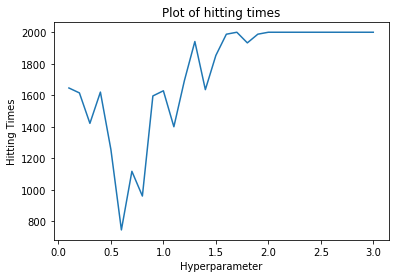

In [11]:
import time
import random

random.seed(21)

def hitting_time_metric(polytope_function, a, b, x0, condition_func, parameter, max_iterations=2000):
    """
    Evaluate hitting time metric for generating points in a polytope.

    Parameters:
    - polytope_function: Function to generate points in the polytope (e.g., dikin_walk or hit_and_run)
    - a: Matrix defining the polytope constraints
    - b: Vector defining the polytope constraints
    - x0: Initial point
    - condition_func: Function defining the condition to be satisfied
    - max_iterations: Maximum number of iterations

    Returns:
    - Tuple containing hitting time and list of generated points
    """

    points = []
    generator = polytope_function(a, b, x0, parameter)
    hitting_time = 0

    for _ in range(max_iterations):
        point = next(generator)
        points.append(point)

        if condition_func(point):
            break

        hitting_time += 1

    return hitting_time, points

# Example usage with Dikin walk
a_matrix = np.array([[1, 0], [-1, 0], [0, 1], [0, -1]])
b_vector = np.array([1, 0, 1, 0])
initial_point = chebyshev_center(a_matrix, b_vector)
print(initial_point)
# Define a condition function (e.g., hitting a specific region)
def condition_func(point):
    return point[0] > 0.9 and point[1] > 0.9

# Evaluate hitting time metric using Dikin walk
listp = []
parameter = 0

hitting_times = []
choose = 20
hit_sum = np.zeros(30)
for j in range(choose):
    listp = []
    parameter = 0
    hit_avg = []
    hitting_times = []
    for i in range(30):
        parameter += 0.1
        listp.append(parameter)
        start_time = time.time()
        hitting_time, dikin_points = hitting_time_metric(dikin_walk, a_matrix, b_vector, initial_point, condition_func,parameter)
        hitting_times.append(hitting_time)
        hit_sum[i] += hitting_time
        end_time = time.time()

print(hit_sum/5)


print(f"Time taken: {end_time - start_time} seconds")
print(hitting_times)
plt.plot(listp, hit_sum/20, linestyle='-')

# Adding labels and title
plt.xlabel('Hyperparameter')
plt.ylabel('Hitting Times')
plt.title('Plot of hitting times')
# Display the plot
plt.show()

[0.5 0.5]


/var/folders/y3/y2wq_hvx7kscqsdrpjl8m6h80000gn/T/ipykernel_8988/1526064350.py:14: RuntimeWarning: divide by zero encountered in power
  s = d ** -2.0
/Users/justinhuang/opt/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


[1440.15 1529.2  1609.7  1427.55 1145.45 1216.65 1209.7  1165.6  1395.95
 1523.6  1680.95 1540.5  1853.45 1859.7  1834.8  1871.5  2000.   1943.85
 2000.   1940.4  1976.45 2000.   2000.   1924.8  2000.   2000.   2000.
 2000.   1959.8  2000.  ]
Time taken: 0.05194878578186035 seconds
[2000, 254, 15, 25, 637, 294, 2000, 369, 2000, 2000, 2000, 2000, 2000, 2000, 1194, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 496, 2000, 2000, 2000, 2000, 2000, 2000]


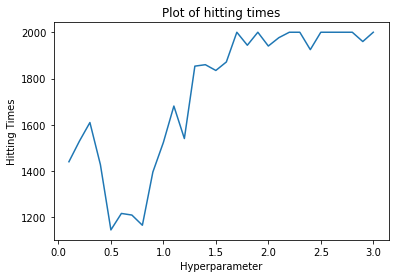

In [10]:
import time
import random

random.seed(21)

def hitting_time_metric(polytope_function, a, b, x0, condition_func, parameter, max_iterations=2000):
    """
    Evaluate hitting time metric for generating points in a polytope.

    Parameters:
    - polytope_function: Function to generate points in the polytope (e.g., dikin_walk or hit_and_run)
    - a: Matrix defining the polytope constraints
    - b: Vector defining the polytope constraints
    - x0: Initial point
    - condition_func: Function defining the condition to be satisfied
    - max_iterations: Maximum number of iterations

    Returns:
    - Tuple containing hitting time and list of generated points
    """

    points = []
    generator = polytope_function(a, b, x0, parameter)
    hitting_time = 0

    for _ in range(max_iterations):
        point = next(generator)
        points.append(point)

        if condition_func(point):
            break

        hitting_time += 1

    return hitting_time, points

# Example usage with Dikin walk
a_matrix = np.array([[1, 0], [-1, 0], [0, 1], [0, -1]])
b_vector = np.array([1, 0, 1, 0])
initial_point = chebyshev_center(a_matrix, b_vector)
print(initial_point)
# Define a condition function (e.g., hitting a specific region)
def condition_func(point):
    return point[0] < 0.1 and point[1] > 0.9

# Evaluate hitting time metric using Dikin walk
listp = []
parameter = 0

hitting_times = []
choose = 20
hit_sum = np.zeros(30)
for j in range(choose):
    listp = []
    parameter = 0
    hit_avg = []
    hitting_times = []
    for i in range(30):
        parameter += 0.1
        listp.append(parameter)
        start_time = time.time()
        hitting_time, dikin_points = hitting_time_metric(dikin_walk, a_matrix, b_vector, initial_point, condition_func,parameter)
        hitting_times.append(hitting_time)
        hit_sum[i] += hitting_time
        end_time = time.time()

print(hit_sum/choose)


print(f"Time taken: {end_time - start_time} seconds")
print(hitting_times)
plt.plot(listp, hit_sum/20, linestyle='-')

# Adding labels and title
plt.xlabel('Hyperparameter')
plt.ylabel('Hitting Times')
plt.title('Plot of hitting times')
# Display the plot
plt.show()

[0.5 0.5]


/var/folders/y3/y2wq_hvx7kscqsdrpjl8m6h80000gn/T/ipykernel_8988/1526064350.py:14: RuntimeWarning: divide by zero encountered in power
  s = d ** -2.0
/Users/justinhuang/opt/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


[1660.55 1530.1  1715.1  1355.5  1619.65 1745.55 1609.2  1761.   1681.95
 1911.45 1952.1  2000.   1917.5  1916.35 2000.   1920.05 2000.   2000.
 2000.   2000.   2000.   2000.   2000.   2000.   2000.   2000.   2000.
 2000.   2000.   2000.  ]
Time taken: 0.04836869239807129 seconds
[539, 2000, 2000, 2000, 2000, 2000, 1513, 2000, 1760, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000]


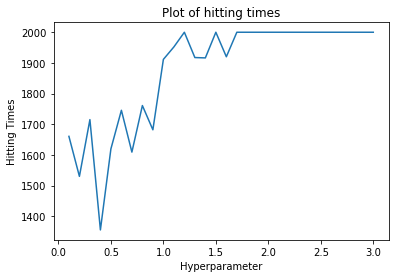

In [5]:
import time
import random

random.seed(21)

def hitting_time_metric(polytope_function, a, b, x0, condition_func, parameter, max_iterations=2000):
    """
    Evaluate hitting time metric for generating points in a polytope.

    Parameters:
    - polytope_function: Function to generate points in the polytope (e.g., dikin_walk or hit_and_run)
    - a: Matrix defining the polytope constraints
    - b: Vector defining the polytope constraints
    - x0: Initial point
    - condition_func: Function defining the condition to be satisfied
    - max_iterations: Maximum number of iterations

    Returns:
    - Tuple containing hitting time and list of generated points
    """

    points = []
    generator = polytope_function(a, b, x0, parameter)
    hitting_time = 0

    for _ in range(max_iterations):
        point = next(generator)
        points.append(point)

        if condition_func(point):
            break

        hitting_time += 1

    return hitting_time, points

# Example usage with Dikin walk
a_matrix = np.array([[1, 0], [-1, 0], [0, 1], [0, -1]])
b_vector = np.array([1, 0, 1, 0])
initial_point = chebyshev_center(a_matrix, b_vector)
print(initial_point)
# Define a condition function (e.g., hitting a specific region)
def condition_func(point):
    return point[0] < 0.05 and point[1] < 0.05

# Evaluate hitting time metric using Dikin walk
listp = []
parameter = 0

hitting_times = []
choose = 20
hit_sum = np.zeros(30)
for j in range(choose):
    listp = []
    parameter = 0
    hit_avg = []
    hitting_times = []
    for i in range(30):
        parameter += 0.1
        listp.append(parameter)
        start_time = time.time()
        hitting_time, dikin_points = hitting_time_metric(dikin_walk, a_matrix, b_vector, initial_point, condition_func,parameter)
        hitting_times.append(hitting_time)
        hit_sum[i] += hitting_time
        end_time = time.time()

print(hit_sum/choose)


print(f"Time taken: {end_time - start_time} seconds")
print(hitting_times)
plt.plot(listp, hit_sum/20, linestyle='-')

# Adding labels and title
plt.xlabel('Hyperparameter')
plt.ylabel('Hitting Times')
plt.title('Plot of hitting times')
# Display the plot
plt.show()

[0.5 0.5]


/var/folders/y3/y2wq_hvx7kscqsdrpjl8m6h80000gn/T/ipykernel_8988/1526064350.py:14: RuntimeWarning: divide by zero encountered in power
  s = d ** -2.0
/Users/justinhuang/opt/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


[1335.58 1442.11 1512.34 1593.93 1441.62 1603.05 1468.58 1515.97 1554.65
 1370.78 1474.61 1515.43 1453.58 1446.39 1470.27 1355.33 1322.75 1323.26
 1390.27 1389.45 1569.29 1506.42 1558.73 1612.89 1673.89 1605.37 1748.7
 1706.56 1792.46 1824.35]
Time taken: 0.05263495445251465 seconds
[2000, 120, 55, 2000, 35, 2000, 2000, 178, 2000, 111, 1715, 2000, 1347, 1976, 2000, 2000, 2000, 853, 2000, 149, 2000, 2000, 2000, 2000, 1149, 2000, 2000, 2000, 303, 2000]


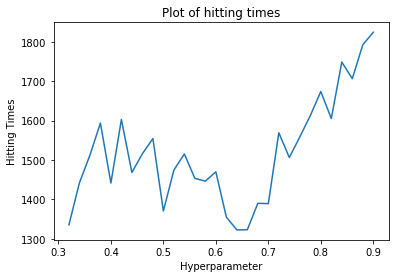

In [14]:
import time
import random

random.seed(21)

def hitting_time_metric(polytope_function, a, b, x0, condition_func, parameter, max_iterations=2000):
    """
    Evaluate hitting time metric for generating points in a polytope.

    Parameters:
    - polytope_function: Function to generate points in the polytope (e.g., dikin_walk or hit_and_run)
    - a: Matrix defining the polytope constraints
    - b: Vector defining the polytope constraints
    - x0: Initial point
    - condition_func: Function defining the condition to be satisfied
    - max_iterations: Maximum number of iterations

    Returns:
    - Tuple containing hitting time and list of generated points
    """

    points = []
    generator = polytope_function(a,b, x0, parameter)
    hitting_time = 0

    for _ in range(max_iterations):
        point = next(generator)
        points.append(point)

        if condition_func(point):
            break

        hitting_time += 1

    return hitting_time, points

# Example usage with Dikin walk
a_matrix = np.array([[1, 0], [-1, 0], [0, 1], [0, -1]])
b_vector = np.array([1, 0, 1, 0])
initial_point = chebyshev_center(a_matrix, b_vector)
print(initial_point)
# Define a condition function (e.g., hitting a specific region)
def condition_func(point):
    return point[0] < 0.05 and point[1] < 0.05

# Evaluate hitting time metric using Dikin walk
listp = []
parameter = 0

hitting_times = []
choose = 100
hit_sum = np.zeros(30)
for j in range(choose):
    listp = []
    parameter = 0.3
    hit_avg = []
    hitting_times = []
    for i in range(30):
        parameter += 0.02
        listp.append(parameter)
        start_time = time.time()
        hitting_time, dikin_points = hitting_time_metric(dikin_walk, a_matrix, b_vector, initial_point, condition_func,parameter)
        hitting_times.append(hitting_time)
        hit_sum[i] += hitting_time
        end_time = time.time()

print(hit_sum/choose)


print(f"Time taken: {end_time - start_time} seconds")
print(hitting_times)
plt.plot(listp, hit_sum/100, linestyle='-')

# Adding labels and title
plt.xlabel('Hyperparameter')
plt.ylabel('Hitting Times')
plt.title('Plot of hitting times')
# Display the plot
plt.show()